In [4]:
import pickle
import argparse
import itertools

import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import sys
sys.path.append('../scripts/query')

import tinystories_distillation as ts

In [5]:
NEW_ROOT='../dummy'
OLD_ROOT='./dummy'

In [17]:
def p_to_logp(p_value):
    return np.log10(p_value)

def get_default_args(save_dir):
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--save_dir', type=str, required=True, help='Directory to save model')
    parser.add_argument('--seed', type=int, default=0, help='Random seed')
    parser.add_argument('--batch_size', type=int, default=4, help='Batch size')
    parser.add_argument('--n_teacher', type=int, default=8, help='Number of training samples')
    parser.add_argument('--n_student', type=int, default=8, help='Number of student samples')
    parser.add_argument('--n_distill', type=int, default=8, help='Number of distillation samples')
    parser.add_argument('--num_teacher_checkpoints', type=int, default=1, help='Number of teacher checkpoints')
    parser.add_argument('--num_student_checkpoints', type=int, default=1, help='Number of student checkpoints')
    parser.add_argument('--num_distillation_checkpoints', type=int, default=1, help='Number of distillation checkpoints')
    parser.add_argument('--teacher_checkpoint_idx', type=int, default=0, help='Teacher checkpoint index')
    parser.add_argument('--student_checkpoint_idx', type=int, default=0, help='Student checkpoint index')
    parser.add_argument('--distillation_checkpoint_idx', type=int, default=0, help='Distillation checkpoint index')
    parser.add_argument('--temperature', type=float, default=1.0, help='Distillation temperature')
    parser.add_argument('--sampling_seed', type=int, default=0, help='Sampling seed')
    parser.add_argument('--prompt', type=str, default=None, help='Prompt')
    parser.add_argument('--max_tokens', type=int, default=64, help='Maximum tokens')
    parser.add_argument('--n_test', type=int, default=1, help='Number of test samples')
    parser.add_argument('--use_reference_model', type=str, default="true", help='Use reference model')
    parser.add_argument('--polyfit_degree', type=int, default=4, help='Polynomial fit degree')
    parser.add_argument('--hidden_size', type=int, default=256, help='Hidden size')
    parser.add_argument('--intermediate_size', type=int, default=512, help='Intermediate size')
    parser.add_argument('--num_hidden_layers', type=int, default=4, help='Number of hidden layers')
    parser.add_argument('--num_attention_heads', type=int, default=8, help='Number of attention heads')
    parser.add_argument('--max_position_embeddings', type=int, default=512, help='Maximum position embeddings')
    parser.add_argument('--learning_rate', type=float, default=1e-5, help='Learning rate')
    parser.add_argument("--include_hash", type=str, default="false")

    args = parser.parse_args(["--save_dir", save_dir])

    return args

def set_args(args, args_dict):
    for k,v in args_dict.items():
        setattr(args, k, v)

def get_experiment(experiment_config, new_root=NEW_ROOT, old_root=OLD_ROOT):
    args = get_default_args(save_dir=old_root)
    set_args(args, experiment_config)
    ts.update_experiment_args(args)

    old_path = ts.get_experiment_log_path(args)
    relative_path = os.path.relpath(old_path, old_root)
    new_path = os.path.join(new_root, relative_path)

    experiment_result = pickle.load(open(new_path,'rb'))
    
    return experiment_result
    

def get_experiment_sweep(
    base_config, 
    sweep_param, 
    sweep_values, 
    transform=None, 
    seed_configs=None, 
    new_root=NEW_ROOT, 
    old_root=OLD_ROOT
):
    if seed_configs is None:
        seed_configs = {"seed": [0]}
    
    sweep_results = {
        "mean": dict(),
        "std": dict()
    }

    seed_names = list(seed_configs.keys())
    seed_values = [seed_configs[name] for name in seed_names]
    seed_combinations = list(itertools.product(*seed_values))
    
    for sweep_value in sweep_values:
        results = []
        for seeds in seed_combinations:
            seed_config = dict(zip(seed_names, seeds))
            
            experiment_config = {k : v for k,v in base_config.items()}
            experiment_config.update(seed_config)
            
            experiment_config[sweep_param] = sweep_value
            
            args = get_default_args(save_dir=old_root)
            set_args(args, experiment_config)
            ts.update_experiment_args(args)

            experiment_result = get_experiment(experiment_config, new_root, old_root)
            results.append(experiment_result["p_value"])

        if transform is not None:
            results = [transform(x) for x in results]
        
        sweep_results["mean"][sweep_value] = np.mean(results)
        sweep_results["std"][sweep_value] = np.std(results)

    return sweep_results

def get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values,
    xlabel=None,
    ylabel="p-value (log-10)",
    styles=None,
    colors=None,
    in_legend=True,
    x_transform=None,
    y_transform=p_to_logp,
    seed_configs=None, 
    new_root=NEW_ROOT, 
    old_root=OLD_ROOT,
    error_bars=False,
):
    if xlabel is None:
        xlabel = sweep_param
    if in_legend is True:
        in_legend = [True] * len(plot_configs)
    sns.set_theme()
    plt.figure() 
    for i,(base_config,legend_tag) in enumerate(zip(plot_configs,plot_names)):
        sweep_results = get_experiment_sweep(
            base_config=base_config, 
            sweep_param=sweep_param, 
            sweep_values=sweep_values, 
            seed_configs=seed_configs,
            transform=y_transform,
            new_root=new_root,
            old_root=old_root,
        )
    
        xs = list(sweep_results['mean'].keys())
        
        m  = np.array([sweep_results['mean'][x] for x in xs], float)
        s  = np.array([sweep_results['std'][x]  for x in xs],  float)

        style = styles[i] if styles else '-'
        color = colors[i] if colors else None
        include = in_legend[i]

        if x_transform is not None:
            xs = [x_transform(x) for x in xs]
        
        plt.plot(xs, m, label=legend_tag if include else None, linestyle=style, color=color)
        if error_bars:
            plt.fill_between(xs, m - s, m + s, alpha=0.2, color=color)
        
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.legend(); plt.tight_layout(); plt.show()

def get_colors(k):
    return plt.rcParams['axes.prop_cycle'].by_key()['color'][:k]

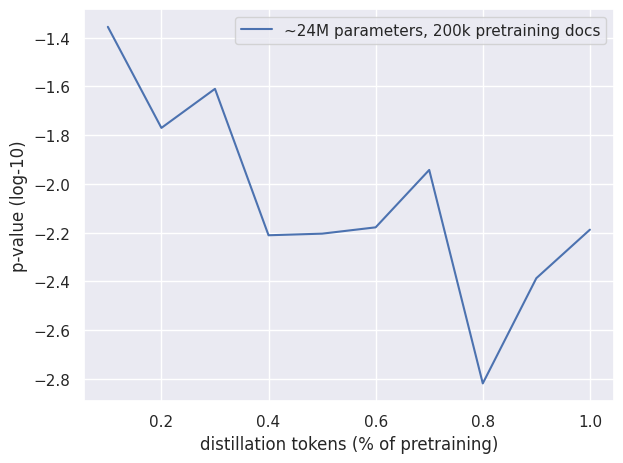

In [18]:
base_config = {
        "n_teacher": 200000,
        "n_student": 20000,
        "n_distill": 200000,
        "n_test": 200000,
        "num_teacher_checkpoints": 10,
        "num_student_checkpoints": 10,
        "num_distillation_checkpoints": 10,
        "teacher_checkpoint_idx": 9,
        "student_checkpoint_idx": 4,
        "hidden_size": 512,
        "intermediate_size": 1024,
        "num_hidden_layers": 8,
    }
sweep_param = "distillation_checkpoint_idx"
sweep_values = list(range(10))
seed_configs = {"seed": [42]}

get_plot(
    plot_configs=[base_config], 
    plot_names=["~24M parameters, 200k pretraining docs"], 
    sweep_param=sweep_param, 
    sweep_values=sweep_values,
    x_transform=lambda x : (x+1)/10,
    y_transform=p_to_logp,
    xlabel="distillation tokens (% of pretraining)",
    seed_configs=seed_configs,
)

In [11]:
10 ** (-1.4)

0.039810717055349734